# Imports

In [1]:
from datetime import datetime as dt
import numpy as np
import pandas as pd
import warnings
import os
import logging
import sys
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
import statsmodels.graphics as smg
import statsmodels.stats as sm_stats
import statsmodels.tsa.api as tsa

In [3]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [4]:
import optuna

In [5]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
import sklearn

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [8]:
#from tqdm import tqdm
from tqdm.notebook import tqdm, tqdm_notebook, tnrange
from tqdm import trange

# Functions

In [9]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    r2 = r2_score(actual, pred)
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2':r2}

## Preprocessing

Data cleaning 

In [295]:
country = 'Brazil'
#country = 'India'
#country = 'US'
#country = country_selection.value

In [296]:
df = pd.read_csv('../Data/'+country+"_daily.csv", index_col=0)

In [297]:
end = dt(year=2021, month=12, day=31)

In [298]:
df.index = pd.to_datetime(df.index)
df2 = df.loc[pd.date_range(start=end, end='2022-02-20')]
df = df.loc[pd.date_range(start='2020-01-22', end=end)]

In [299]:
def fix_outliers(df,q = .99, zero = True):
  # cortar período inicial sem casos
  for k,d in enumerate(df):
    if k > 0 and d > df.iloc[k-1]:
      break
  df = df.iloc[k:]
  # substituir zeros
  if zero == False:
    df = df.mask(df == 0, np.nan).fillna(method='bfill')
  # converter valores extremos para NaN e substituir pelo anterior
  df = df.mask(df > df.quantile(q), np.nan).fillna(method='bfill')
  df = df.mask(df < 0, np.nan).fillna(0)
  return df

In [300]:
data = fix_outliers(df)

In [301]:
data2 = fix_outliers(df2)

In [302]:
train_data = data.iloc[:int(len(data)*0.7)] 
val_data = data.iloc[int(len(data)*0.7):int(len(data)*0.9)]
test_data = data.iloc[-int(len(data)*0.1):]

# Split

In [303]:
X_train = pd.DataFrame(tsa.add_lag(train_data, lags =14))
#X_train = pd.DataFrame(tsa.add_lag(train_data.diff().dropna(), lags =14))
y_train = torch.from_numpy(X_train.pop(0).values.reshape(-1,1)).float()

In [304]:
X_val = pd.DataFrame(tsa.add_lag(val_data, lags =14))
#X_train = pd.DataFrame(tsa.add_lag(train_data.diff().dropna(), lags =14))
y_val = torch.from_numpy(X_val.pop(0).values.reshape(-1,1)).float()

In [305]:
#X_test = pd.DataFrame(tsa.add_lag(test_data, lags =14))
X_test = pd.DataFrame(tsa.add_lag(test_data, lags =14))
y_test = torch.from_numpy(X_test.pop(0).values.reshape(-1,1)).float()

# Normalização

In [306]:
X_train_sd = ((X_train - train_data.mean())/train_data.std()).values
X_train_sd = torch.from_numpy(X_train_sd).float()
X_val_sd = ((X_val - train_data.mean())/train_data.std()).values
X_val_sd = torch.from_numpy(X_val_sd).float()
X_test_sd = ((X_test - train_data.mean())/train_data.std()).values
X_test_sd = torch.from_numpy(X_test_sd).float()

In [307]:
min_value = float(train_data.min())
base = float(train_data.max()) - float(train_data.min())

X_train_mm = (X_train - min_value)/base
X_val_mm = (X_val - min_value)/base
X_test_mm = (X_test - min_value)/base

In [308]:
min_value = float(train_data.min())
base = float(train_data.max()) - float(train_data.min())

X_train_mm = ((X_train - min_value)/base).to_numpy()
X_train_mm = torch.from_numpy(X_train_mm).float()
X_val_mm = ((X_val - min_value)/base).to_numpy()
X_val_mm = torch.from_numpy(X_val_mm).float()
X_test_mm = ((X_test - min_value)/base).to_numpy()
X_test_mm = torch.from_numpy(X_test_mm).float()

# ELM



In [309]:
import torch
import torch.nn as nn
import torch.optim as optim

In [310]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [311]:
class ELM():
    def __init__(self, input_size, h_size, activation, device=None):
        self._input_size = input_size
        self._h_size = h_size
        self._output_size = 1
        self._device = device

        self._alpha = nn.init.uniform_(torch.empty(self._input_size, self._h_size, device=self._device), a=-1., b=1.)
        self._beta = nn.init.uniform_(torch.empty(self._h_size, self._output_size, device=self._device), a=-1., b=1.)

        self._bias = torch.zeros(self._h_size, device=self._device)

        if activation == 'tanh':
            self._activation = torch.tanh
        elif activation == 'relu':
            self._activation = torch.relu
        elif activation == 'sigmoid':
            self._activation = torch.sigmoid

    def predict(self, x):
        h = self._activation(torch.add(x.mm(self._alpha), self._bias))
        out = h.mm(self._beta)

        return out

    def fit(self, x, t):
        temp = x.mm(self._alpha)
        H = self._activation(torch.add(temp, self._bias))

        H_pinv = torch.pinverse(H)
        self._beta = H_pinv.mm(t)

In [312]:
def objective(trial):

    #h_size = trial.suggest_int("h_size", 2, 20)
    h_size = trial.suggest_int("h_size", 2, 200)
    activation = trial.suggest_categorical("activation", ["sigmoid", "tanh", "relu"])
    # Generate the model.
    results = np.zeros(10)
    
    for i in range(10):
        model = ELM(input_size=14, h_size=h_size, activation=activation, device=device)
        model.fit(X_train_mm, y_train)
        y_pred = model.predict(X_val_mm)
        mse = -mean_squared_error(y_val, y_pred)
        results[i] = mse

    return results.mean()

In [313]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(0)
study_name = "elm-study-"+country+str(dt.now())  # Unique identifier of the study.
storage_name = "sqlite:///db/{}.db".format(study_name)

In [314]:
%%time
study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
#study = optuna.create_study(direction="minimize", study_name=study_name)
study.optimize(objective, n_trials=60, show_progress_bar=True)
print(study.best_trial)

100%|██████████| 60/60 [00:08<00:00,  6.73it/s]

FrozenTrial(number=48, values=[-45804800.0], datetime_start=datetime.datetime(2022, 5, 5, 18, 24, 13, 550858), datetime_complete=datetime.datetime(2022, 5, 5, 18, 24, 13, 652652), params={'activation': 'sigmoid', 'h_size': 36}, distributions={'activation': CategoricalDistribution(choices=('sigmoid', 'tanh', 'relu')), 'h_size': IntUniformDistribution(high=200, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=49, state=TrialState.COMPLETE, value=None)
CPU times: user 4.61 s, sys: 2.69 s, total: 7.31 s
Wall time: 9.3 s


In [315]:
df_trials = [{'value': t.value, 'h_size': t.params['h_size'], 'actv': t.params['activation']}  for t in study.trials]
#pd.DataFrame.from_records(df_trials)

<AxesSubplot:xlabel='h_size', ylabel='value'>

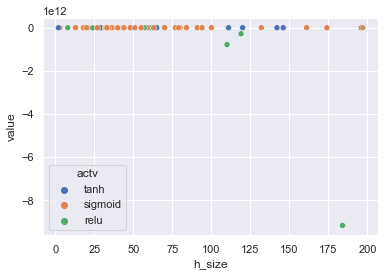

In [316]:
sns.scatterplot(data= pd.DataFrame(df_trials), x='h_size', y='value', hue='actv')

In [317]:
importance = optuna.importance.get_param_importances(study)

<AxesSubplot:title={'center':'importance'}>

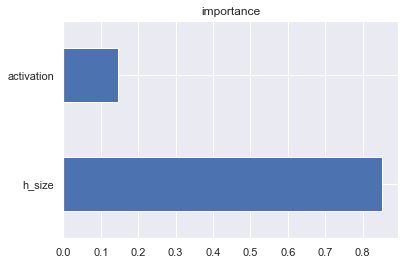

In [318]:
pd.Series(importance).plot.barh(title='importance')

In [319]:
params = study.best_params
params

{'activation': 'sigmoid', 'h_size': 36}

In [320]:
best_elm = ELM(input_size=14, h_size=params['h_size'], activation=params['activation'], device=device)

In [321]:
%%time
best_elm.fit(X_train_mm, y_train)

CPU times: user 2.28 ms, sys: 946 µs, total: 3.22 ms
Wall time: 2.09 ms


In [322]:
metrics = eval_metrics(y_test, best_elm.predict(X_test_mm))
metrics

{'rmse': 2136.7756,
 'mae': 1705.8247,
 'mape': 0.31775093,
 'r2': 0.7052829692336035}

In [323]:
elm = ELM(input_size=14, h_size=20, activation='relu', device=device)

In [324]:
elm = ELM(input_size=14, h_size=20, activation='relu', device=device)
elm.fit(X_train_mm, y_train)
eval_metrics(y_test, elm.predict(X_test_mm))

{'rmse': 2898.702,
 'mae': 2350.109,
 'mape': 0.42884332,
 'r2': 0.45763151017648385}

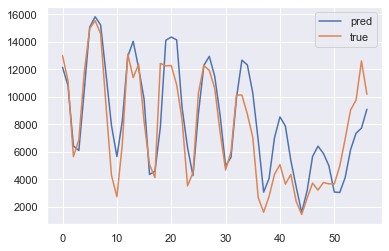

In [325]:
fig, ax = plt.subplots()
ax.plot(best_elm.predict(X_test_mm).flatten(), label='pred')
ax.plot(y_test, label='true')
plt.legend()

In [326]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///db/{}.db".format(study_name))

In [327]:
tables = pd.read_sql("SELECT name FROM sqlite_schema WHERE type ='table' AND name NOT LIKE 'sqlite_%';", engine)
tables

,name
0,studies
1,version_info
2,study_directions
3,study_user_attributes
4,study_system_attributes
5,trials
6,trial_user_attributes
7,trial_system_attributes
8,trial_params
9,trial_values


In [328]:
trials = pd.read_sql("SELECT * FROM trials T \
    JOIN trial_values TV ON T.trial_id = TV.trial_id \
    JOIN trial_params TP ON T.trial_id = TP.trial_id;", engine)
trials


,trial_id,number,study_id,state,datetime_start,datetime_complete,trial_value_id,trial_id,objective,value,param_id,trial_id,param_name,param_value,distribution_json
0,1,0,1,COMPLETE,2022-05-05 18:24:07.088910,2022-05-05 18:24:07.211411,1,1,0,-133734448.0,1,1,h_size,196.0,"{""name"": ""IntUniformDistribution"", ""attributes..."
1,1,0,1,COMPLETE,2022-05-05 18:24:07.088910,2022-05-05 18:24:07.211411,1,1,0,-133734448.0,2,1,activation,1.0,"{""name"": ""CategoricalDistribution"", ""attribute..."
2,2,1,1,COMPLETE,2022-05-05 18:24:07.261027,2022-05-05 18:24:07.357784,2,2,0,-71304232.0,3,2,h_size,120.0,"{""name"": ""IntUniformDistribution"", ""attributes..."
3,2,1,1,COMPLETE,2022-05-05 18:24:07.261027,2022-05-05 18:24:07.357784,2,2,0,-71304232.0,4,2,activation,1.0,"{""name"": ""CategoricalDistribution"", ""attribute..."
4,3,2,1,COMPLETE,2022-05-05 18:24:07.396055,2022-05-05 18:24:07.497428,3,3,0,-111138720.0,5,3,h_size,161.0,"{""name"": ""IntUniformDistribution"", ""attributes..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,58,57,1,COMPLETE,2022-05-05 18:24:15.643470,2022-05-05 18:24:15.728973,58,58,0,-47547076.0,116,58,activation,0.0,"{""name"": ""CategoricalDistribution"", ""attribute..."
116,59,58,1,COMPLETE,2022-05-05 18:24:15.769678,2022-05-05 18:24:15.848994,59,59,0,-56143116.0,117,59,h_size,63.0,"{""name"": ""IntUniformDistribution"", ""attributes..."
117,59,58,1,COMPLETE,2022-05-05 18:24:15.769678,2022-05-05 18:24:15.848994,59,59,0,-56143116.0,118,59,activation,0.0,"{""name"": ""CategoricalDistribution"", ""attribute..."
118,60,59,1,COMPLETE,2022-05-05 18:24:15.876511,2022-05-05 18:24:15.969278,60,60,0,-49683740.0,119,60,h_size,20.0,"{""name"": ""IntUniformDistribution"", ""attributes..."
